# Import Library and Dataset

In [ ]:
#Import Library
import sklearn.metrics as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.svm import SVR
from tabulate import tabulate
from dateutil.relativedelta import relativedelta

In [ ]:
#Load Dataset
from google.colab import files
uploaded = files.upload()

Saving Bali 2015 - 2022.csv to Bali 2015 - 2022.csv


# Processing Data

In [ ]:
#Import Data
data = pd.read_csv("Bali 2015 - 2022.csv", index_col='datetime', parse_dates=['datetime'])
data.head()

,total_visitor,total_accomodation
datetime,,
2014-01-01,279257,16495
2014-02-01,275795,17221
2014-03-01,276573,17330
2014-04-01,280096,17737
2014-05-01,286033,18836


In [ ]:
import sklearn.preprocessing

def normalize_fn(data, columns):
    scaler_object = sklearn.preprocessing.MinMaxScaler()

    for col in columns:
        data[col] = scaler_object.fit_transform(data[col].values.reshape(-1, 1))

    return data

In [ ]:
columns_to_normalize = ['total_visitor', 'total_accomodation']
normalized_data = normalize_fn(data, columns_to_normalize)
normalized_data

,total_visitor,total_accomodation
datetime,,
2014-01-01,0.447265,0.000000
2014-02-01,0.441720,0.017366
2014-03-01,0.442966,0.019973
2014-04-01,0.448609,0.029708
2014-05-01,0.458118,0.055995
...,...,...
2022-08-01,0.443104,0.943311
2022-09-01,0.466332,0.950511
2022-10-01,0.488886,0.959552


# Scenario 1 - 80% Train - 20% Test

In [ ]:
#splitting data
X = normalized_data.iloc[ : , [1]].values
y = normalized_data.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [ ]:
# Create SVR model
param_grid = {
    'C': [0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 1,],
    'kernel': ['linear', 'rbf']
}

svr = SVR()
grid_search = GridSearchCV(estimator=SVR(), param_grid=param_grid, refit=True, verbose=2, cv=2)

In [ ]:
# Fit the model with the best parameters
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END ................C=0.01, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END ................C=0.01, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END .................C=0.01, epsilon=0.1, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, epsilon=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.01, epsilon=0.1, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, epsilon=0.1, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, epsilon=1, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, epsilon=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.01, epsilon=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, epsilon=1

GridSearchCV(cv=2, estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1], 'epsilon': [0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [ ]:
# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}


In [ ]:
# Make predictions with the best model
best_regressor = grid_search.best_estimator_
y_pred = best_regressor.predict(X_test)

In [ ]:
# Evaluate the model
mse = sm.mean_squared_error(y_test, y_pred)
mae = sm.mean_absolute_error(y_test, y_pred)
mape = f"{(mae*100):.2f}%"

print("MSE:", mse)
print("MAE:", mae)
print("MAPE:", mape)

MSE: 0.01646096259411762
MAE: 0.08228294454650277
MAPE: 8.23%


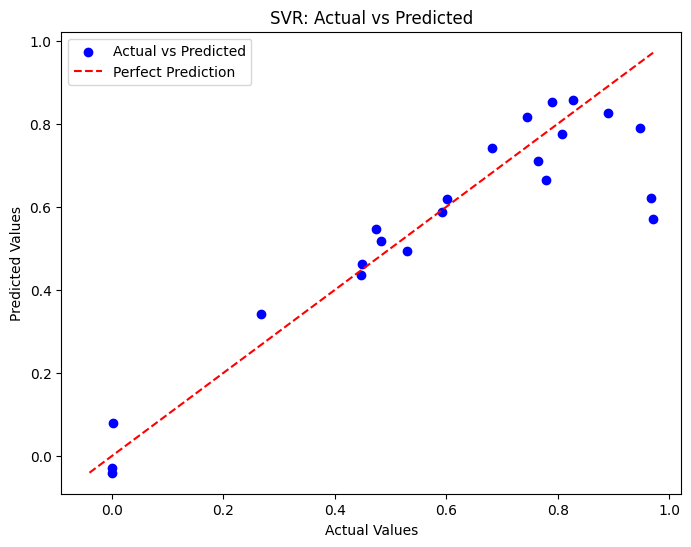

In [ ]:
# Scatter plot to visualize training result
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted')
# Plotting the diagonal line (perfect prediction)
max_value = max(max(y_test), max(y_pred))
min_value = min(min(y_test), min(y_pred))
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Perfect Prediction')

plt.title('SVR: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [ ]:
# Extend predictions to the future
future_timeframe = 12  # Based on future months

# Use the best model to predict future values
future_index = np.arange(len(X), len(X) + future_timeframe).reshape(-1, 1)
future_predictions = grid_search.predict(future_index)

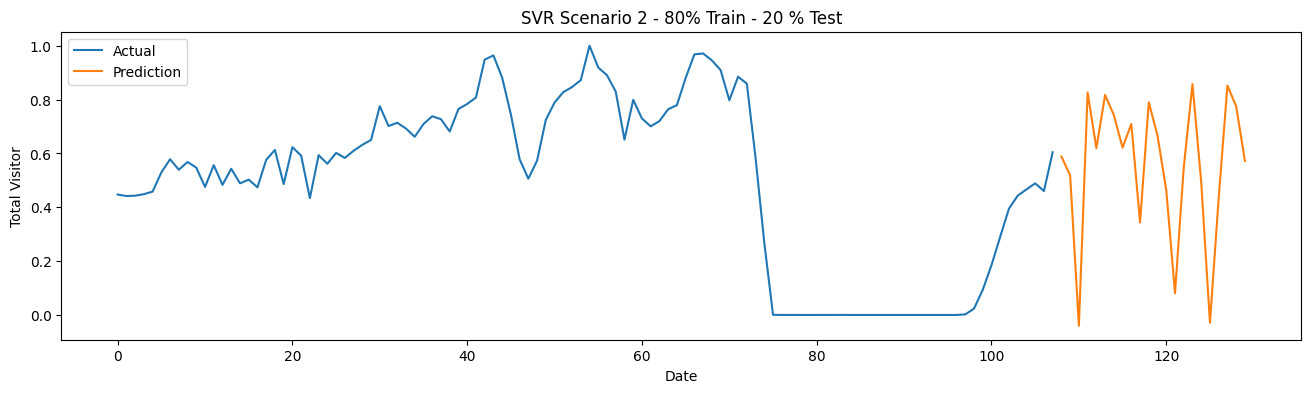

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │    0.588473  │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │    0.518498  │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │   -0.0399784 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │    0.826082  │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │    0.619397  │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │    0.81694   │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │    0.742732  │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │    0.62162   │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │    0.709543  │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │    0.343365  │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │    0.789656  │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

In [ ]:
# Plotting
plt.figure(figsize=(16, 4))

# Plotting the actual values
plt.plot(y, label='Actual')

# Plotting the extended predictions
plt.plot(np.arange(len(y), len(y) + len(y_test)), y_pred, label='Prediction')

plt.title('SVR Scenario 2 - 80% Train - 20 % Test')
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()

# Generate the forecast dates from January 2023 to December 2023
forecast_dates = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

# Create a list of forecast dates and prediction values
data = list(zip(forecast_dates, y_pred))

# Create a list of headers for the table
headers = ['Date', 'Prediction']
table = tabulate(data, headers=headers, tablefmt='fancy_grid')
# Print the table
print(table)

# Scenario 2 - 70% Train - 30 % Test

In [ ]:
#splitting data
X2 = normalized_data.iloc[ : , [1]].values
y2 = normalized_data.iloc[:, 0].values

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.30)

In [ ]:
# Create SVR model
param_grid = {
    'C': [0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 1,],
    'kernel': ['linear', 'rbf']
}

svr = SVR()
grid_search2 = GridSearchCV(estimator=SVR(), param_grid=param_grid, refit=True, verbose=2, cv=2)

In [ ]:
# Fit the model with the best parameters
grid_search2.fit(X2_train, y2_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END ................C=0.01, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END ................C=0.01, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END .................C=0.01, epsilon=0.1, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, epsilon=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.01, epsilon=0.1, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, epsilon=0.1, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, epsilon=1, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, epsilon=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.01, epsilon=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, epsilon=1

GridSearchCV(cv=2, estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1], 'epsilon': [0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [ ]:
# Get the best parameters found by GridSearchCV
best_params2 = grid_search2.best_params_
print("Best Parameters:", best_params2)

Best Parameters: {'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}


In [ ]:
# Make predictions with the best model
best_regressor2 = grid_search2.best_estimator_
y2_pred = best_regressor2.predict(X2_test)

In [ ]:
# Evaluate the model
mse2 = sm.mean_squared_error(y2_test, y2_pred)
mae2 = sm.mean_absolute_error(y2_test, y2_pred)
mape2 = f"{(mae2*100):.2f}%"

print("MSE:", mse2)
print("MAE:", mae2)
print("MAPE:", mape2)

MSE: 0.01424348892905764
MAE: 0.08598094678427899
MAPE: 8.60%


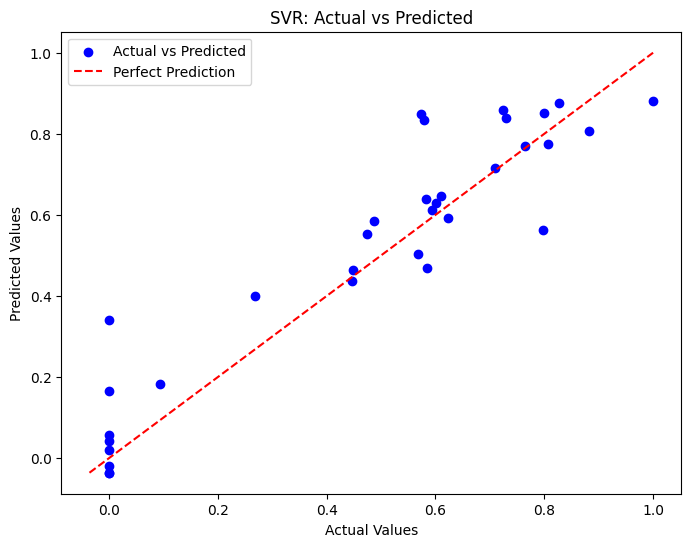

In [ ]:
# Scatter plot to visualize training result
plt.figure(figsize=(8, 6))
plt.scatter(y2_test, y2_pred, color='blue', label='Actual vs Predicted')
# Plotting the diagonal line (perfect prediction)
max_value = max(max(y2_test), max(y2_pred))
min_value = min(min(y2_test), min(y2_pred))
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Perfect Prediction')

plt.title('SVR: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [ ]:
# Extend predictions to the future
future_timeframe = 12  # Based on future months

# Use the best model to predict future values
future_index = np.arange(len(X), len(X) + future_timeframe).reshape(-1, 1)
future_predictions2 = grid_search2.predict(future_index)

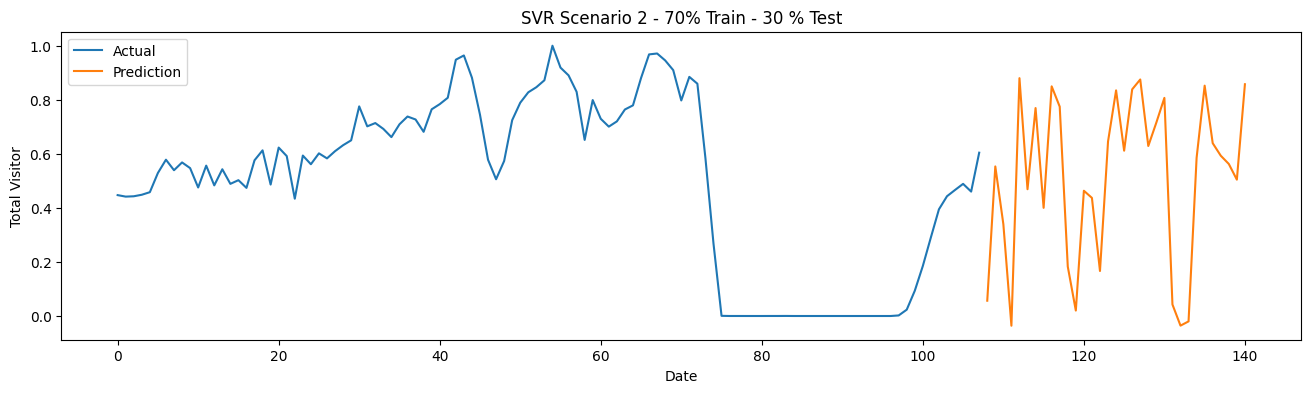

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │    0.0565772 │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │    0.553372  │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │    0.339668  │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │   -0.0359581 │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │    0.880001  │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │    0.469065  │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │    0.769369  │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │    0.400195  │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │    0.849724  │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │    0.774546  │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │    0.182904  │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

In [ ]:
# Plotting
plt.figure(figsize=(16, 4))

# Plotting the actual values
plt.plot(y2, label='Actual')

# Plotting the extended predictions
plt.plot(np.arange(len(y2), len(y2) + len(y2_test)), y2_pred, label='Prediction')

plt.title('SVR Scenario 2 - 70% Train - 30 % Test')
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()

# Generate the forecast dates from January 2023 to December 2023
forecast_dates_2 = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

# Create a list of forecast dates and prediction values
data2 = list(zip(forecast_dates_2, y2_pred))

# Create a list of headers for the table
headers = ['Date', 'Prediction']
table2 = tabulate(data2, headers=headers, tablefmt='fancy_grid')
# Print the table
print(table2)

# Scenario 3 - 60% Train - 40 % Test

In [ ]:
#splitting data
X3 = normalized_data.iloc[ : , [1]].values
y3 = normalized_data.iloc[:, 0].values

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.40)

In [ ]:
# Create SVR model
param_grid = {
    'C': [0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 1,],
    'kernel': ['linear', 'rbf']
}

svr = SVR()
grid_search3 = GridSearchCV(estimator=SVR(), param_grid=param_grid, refit=True, verbose=2, cv=2)

In [ ]:
# Fit the model with the best parameters
grid_search3.fit(X3_train, y3_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END ................C=0.01, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END ................C=0.01, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, epsilon=0.01, kernel=rbf; total time=   0.0s
[CV] END .................C=0.01, epsilon=0.1, kernel=linear; total time=   0.0s
[CV] END .................C=0.01, epsilon=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.01, epsilon=0.1, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, epsilon=0.1, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.01, epsilon=1, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, epsilon=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.01, epsilon=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, epsilon=1

GridSearchCV(cv=2, estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1], 'epsilon': [0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [ ]:
# Get the best parameters found by GridSearchCV
best_params3 = grid_search3.best_params_
print("Best Parameters:", best_params3)

Best Parameters: {'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}


In [ ]:
# Make predictions with the best model
best_regressor3 = grid_search3.best_estimator_
y3_pred = best_regressor3.predict(X3_test)

In [ ]:
# Evaluate the model
mse3 = sm.mean_squared_error(y3_test, y3_pred)
mae3 = sm.mean_absolute_error(y3_test, y3_pred)
mape3 = f"{(mae3*100):.2f}%"

print("MSE:", mse3)
print("MAE:", mae3)
print("MAPE:", mape3)

MSE: 0.020523003694153896
MAE: 0.10140133840877265
MAPE: 10.14%


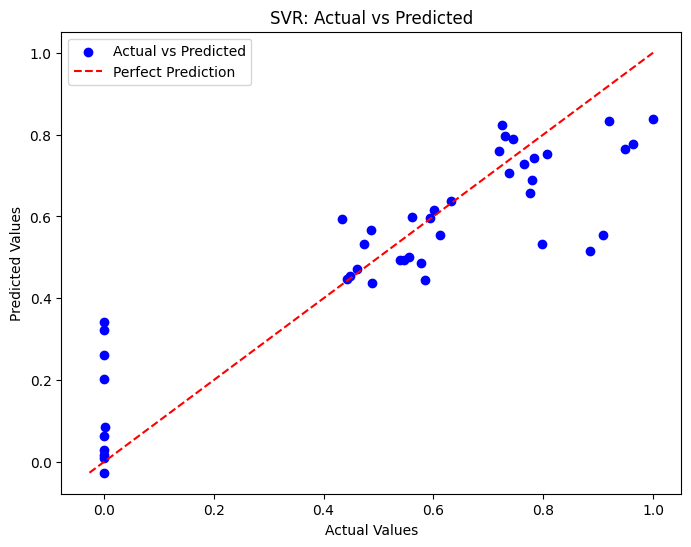

In [ ]:
# Scatter plot to visualize training result
plt.figure(figsize=(8, 6))
plt.scatter(y3_test, y3_pred, color='blue', label='Actual vs Predicted')
# Plotting the diagonal line (perfect prediction)
max_value = max(max(y3_test), max(y3_pred))
min_value = min(min(y3_test), min(y3_pred))
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Perfect Prediction')

plt.title('SVR: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [ ]:
# Extend predictions to the future
future_timeframe = 12  # Based on future months

# Use the best model to predict future values
future_index = np.arange(len(X), len(X) + future_timeframe).reshape(-1, 1)
future_predictions3 = grid_search3.predict(future_index)

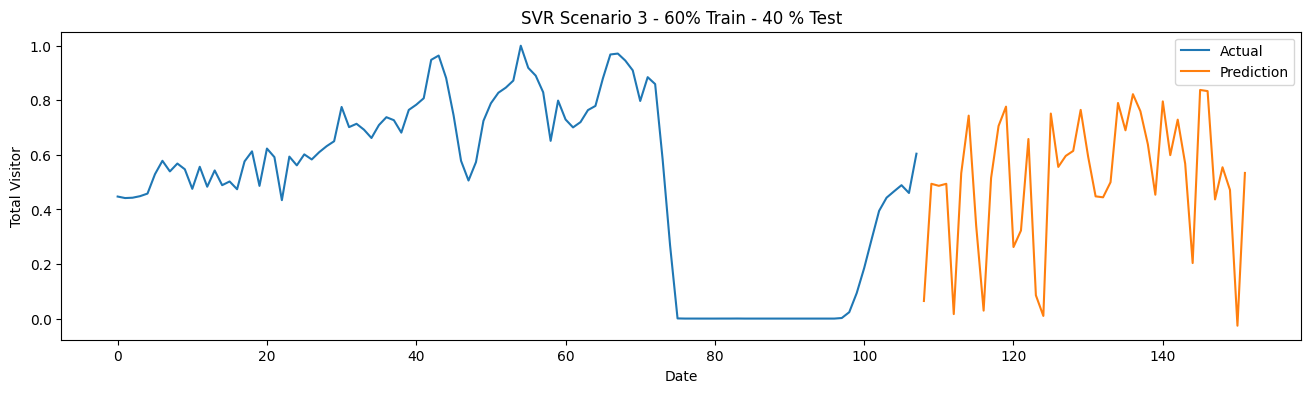

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │    0.0644311 │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │    0.494004  │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │    0.48661   │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │    0.494004  │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │    0.0164759 │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │    0.53269   │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │    0.743779  │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │    0.340937  │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │    0.0291782 │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │    0.51528   │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │    0.705833  │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

In [ ]:
# Plotting
plt.figure(figsize=(16, 4))

# Plotting the actual values
plt.plot(y3, label='Actual')

# Plotting the extended predictions
plt.plot(np.arange(len(y3), len(y3) + len(y3_test)), y3_pred, label='Prediction')

plt.title('SVR Scenario 3 - 60% Train - 40 % Test')
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()

# Generate the forecast dates from January 2023 to December 2023
forecast_dates_3 = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

# Create a list of forecast dates and prediction values
data3 = list(zip(forecast_dates_3, y3_pred))

# Create a list of headers for the table
headers = ['Date', 'Prediction']
table3 = tabulate(data3, headers=headers, tablefmt='fancy_grid')
# Print the table
print(table3)

# Conclusion

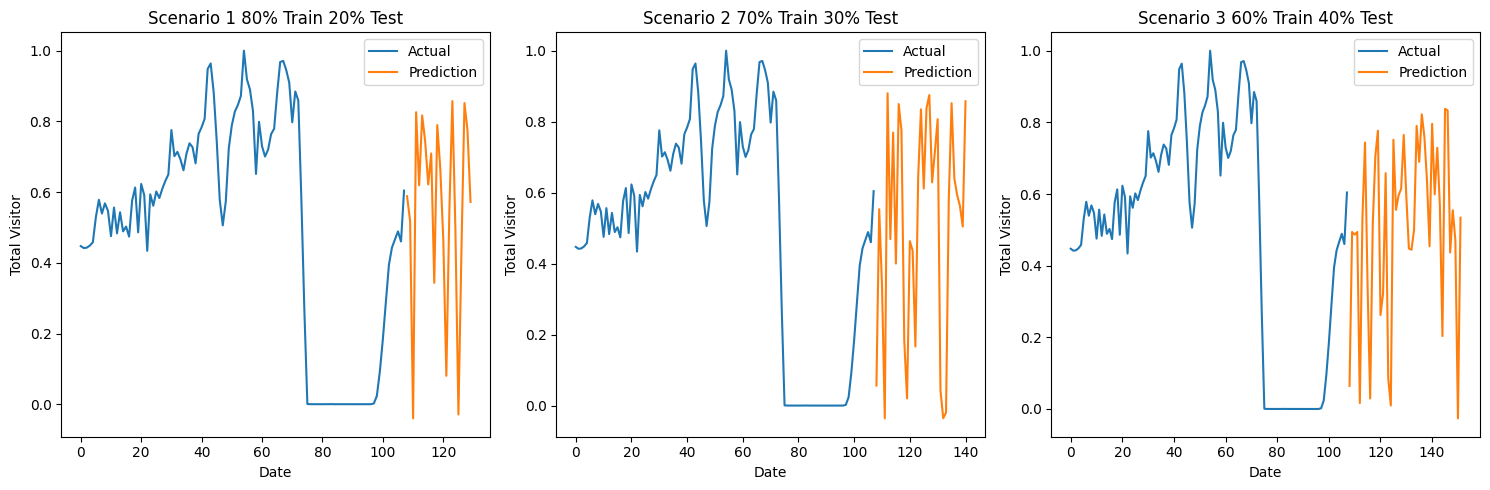

╒════════════╤═════════╤═══════════╤═══════════╤════════╕
│ Scenario   │ Model   │       MAE │       MSE │ MAPE   │
╞════════════╪═════════╪═══════════╪═══════════╪════════╡
│ Scenario 1 │ SVR     │ 0.0822829 │ 0.016461  │ 8.23%  │
├────────────┼─────────┼───────────┼───────────┼────────┤
│ Scenario 2 │ SVR     │ 0.0859809 │ 0.0142435 │ 8.60%  │
├────────────┼─────────┼───────────┼───────────┼────────┤
│ Scenario 3 │ SVR     │ 0.101401  │ 0.020523  │ 10.14% │
╘════════════╧═════════╧═══════════╧═══════════╧════════╛


In [ ]:
plt.figure(figsize=(15, 5))

# Scenario 1
plt.subplot(1, 3, 1)
plt.plot(y, label='Actual')
plt.plot(np.arange(len(y), len(y) + len(y_test)), y_pred, label='Prediction')
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.title('Scenario 1 80% Train 20% Test')
plt.legend()

# Scenario 2
plt.subplot(1, 3, 2)
plt.plot(y2, label='Actual')
plt.plot(np.arange(len(y2), len(y2) + len(y2_test)), y2_pred, label='Prediction')
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.title('Scenario 2 70% Train 30% Test')
plt.legend()

# Scenario 3
plt.subplot(1, 3, 3)
plt.plot(y3, label='Actual')
plt.plot(np.arange(len(y3), len(y3) + len(y3_test)), y3_pred, label='Prediction')
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.title('Scenario 3 60% Train 40% Test')
plt.legend()

plt.tight_layout()
plt.show()

# Define the data for each scenario
scenario_data = [
    {
        'Scenario': 'Scenario 1',
        'Model': 'SVR',
        'MAE': mae,
        'MSE': mse,
        'MAPE': mape
    },
    {
        'Scenario': 'Scenario 2',
        'Model': 'SVR',
        'MAE': mae2,
        'MSE': mse2,
        'MAPE': mape2
    },
    {
        'Scenario': 'Scenario 3',
        'Model': 'SVR',
        'MAE': mae3,
        'MSE': mse3,
        'MAPE': mape3
    }
]

# Create a DataFrame from the scenario data
df = pd.DataFrame(scenario_data)

# Convert DataFrame to a list of rows
rows = df.values.tolist()

# Create a list of headers
headers = df.columns.tolist()

# Generate the table
table4 = tabulate(rows, headers=headers, tablefmt='fancy_grid')

# Print the table
print(table4)